# Desmistificando la transformada de ondeletas

<a href="https://juanfonsecasolis.github.io/">Juan M. Fonseca-Solís</a> · Febrero 2021 · 5 min read

---

## Resumen

La transformada de ondeletas (o _wavelets_ como se conocen en inglés) es una herramienta de análisis de señales que fue planteada como alternativa a la transformada de Fourier de corto plazo para resolver el problema del principio de incertidumbre de Heinserberg. Aplicado a procesamiento de señales, este principio estipula que al obtener mayor resolución frecuencial se obtiene menor resolución temporal, y viceversa, lo cual es un problema para analizar señales con contenido espectral desconocido o cuando hay mezcladas frecuencias muy altas y muy bajas. Amplia literatura se encuentra sobre el tema, pero queremos convencernos por nosotros mismos de la eficacia de este método. En este ipython notebook estudiamos un ejemplo usando la transformada de ondeletas continua (por sus siglas en inglés) para analizar un barrido de frecuencias en el tiempo, una señal difícil de analizar. Los resultados aún están por definirse...

# Introducción
En construcción...

# Definición de ondeleta

Una ondeleta se define como una señal de energía finita y corta duración, que debe cumplir dos condiciones, el tener media cero [2]:

$$
\int_{-\infty}^{\infty}{\psi(t)dt} = 0,
$$

y satisfacer el principio de admisibilidad:

$$
C_{\psi} = \int_{-\infty}^{\infty}{\frac{|\Psi(\omega)|^2}{|\omega|}d\omega} < \infty,
$$

donde $\Psi(\omega)=\mathscr{F}\{\psi(t)\}$, es decir, la transformada de Fourier de la ondeleta en términos de radianes por segundo (recordando que $\omega=2\pi f$, con $f$ la frecuencia en hercios). La segunda condición es lo que diferencia una ondeleta de, por ejemplo, un senoidal, que tiene energía infinita. Un ejemplo de una ondeleta es la _ondeleta sombrero_ o función Ricker, que se define como sigue ($\sigma$ parece controlar la amplitud del lóbulo principal) [1]:

$$
\psi(t) = \frac{2}{\sqrt{3\sigma}\pi^{1/4}} \left({1-{\left({\frac{t}{\sigma}}\right)}^2}\right) e^{-\frac{t^2}{2\sigma^2}}
$$

Populating the interactive namespace from numpy and matplotlib


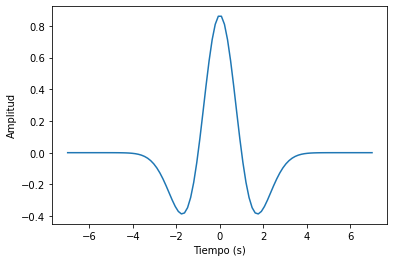

In [167]:
%pylab inline
from scipy import signal
import numpy as np

def sombrero(x,sigma=1.0):
    return (2/(np.sqrt(3*sigma)*np.pi**0.25)) * (1-(x*sigma)**2) * (np.exp(-(x**2)/(2*sigma**2)))

x = np.linspace(-7,7,100)
plt.plot(x,sombrero(x))
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.show()

A partir de una función como esta, es posible definir la _ondeleta madre_ que permite derivar otras ondeletas de la misma forma haciendo uso de una serie de escalamientos y desplazamientos (definidos según los parámetros $a$ y $b$, respectivamente):

$$
\psi_{a,b}(t) = \frac{1}{\sqrt{a}}\,\psi\left(\frac{t-b}{a}\right).
$$

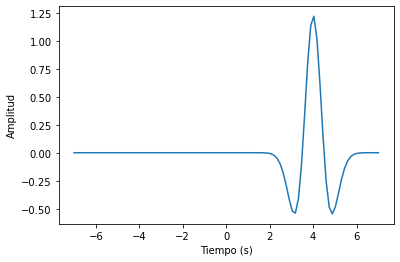

In [169]:
def ondeletaMadre(x,a,b,ondeletaFunc):
    return 1.0/np.sqrt(a) * ondeletaFunc((x-b)/a)

plt.plot(x,ondeletaMadre(x,a=0.5,b=4,ondeletaFunc=sombrero)) # retrasar 2 segundos y cambiar ancho a la mitad
plt.xlabel('Tiempo (s)')
plt.ylabel('Amplitud')
plt.show()

# La transformada continua de ondeleta

La ondeleta madre permite definir otro concepto llamado la _transformada de ondeleta continua_ (CWT, por sus siglas en inglés), que permite analizar una señal mediante la siguiente ecuación [2]:

$$
\text{CWT}_f(a,b) = \int_{-\infty}^{\infty}{\psi^{*}_{a,b}(t)f(t)dt},  
$$

donde el operador $\cdot^{*}$, haciendo un repaso de la definición del producto punto o escalar (no confundir con el producto interno), representa el conjugado complejo: $(a+bi)^{*}=a-bi$. El lector algido notará que esto no es otra cosa de la correlación entre la ondeleta (escalada y trasladada) y la función. Lo mismo ocurre con la _transformada de Fourier_, donde exponenciales complejas se correlacionan con la señal. Existe también otras transformadas, como la _transformada de ondeleta discreta_ (DWT, por sus siglas en inglés) que no vamos a considerar en este ipython notebook [3].

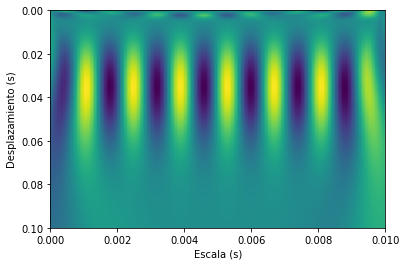

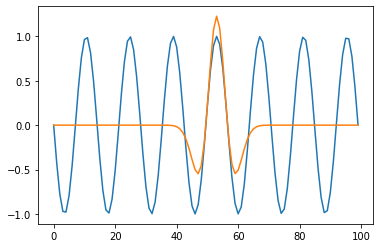

In [199]:
def CWT(f,a,b,ondeleta=sombrero):
    return np.dot(ondeletaMadre(np.arange(0,len(f)),a,b,ondeleta), f)

F0 = 500 # frec. fundamental (Hz)
Fs = 2*F0 # frec. Nyquist
N = 3*F0 # mostrar cinco periodos de la senal

y = np.sin(np.pi*F0/(Fs/2)*x) # f=F0/Fs: frecuencia discreta

A = np.linspace(0.1,10,100)
B = np.linspace(0.1,100,100)
F = np.zeros([len(A),len(B)])
for iA in range(0,len(A)):
    for iB in range(0,len(B)):
        F[iA,iB]=CWT(y,A[iA],B[iB])
        
plt.imshow(F,aspect='auto', extent=[0, A[-1]/Fs, B[-1]/Fs,0]) # extend: (left, right, bottom, top)
plt.ylabel('Desplazamiento (s)')
plt.xlabel('Escala (s)')
show()

figure()
plt.plot(y[0:500])
plt.plot(ondeletaMadre(x,a=0.5,b=0.5,ondeletaFunc=sombrero))
show()

# Escalograma

El escalograma es a la transforma de ondeletas lo que un espectrograma (transforma de Fourier de corto plazo) es a la transformada de Fourier. A diferencia de un espectrograma, el escalograma no está limitado por el principio de Incertidumbre de Heisenberg aplicado a señales, que dice que a mayor resolución temporal, menor resolución frecuencial y viceversa. Esto ocurre porque...

Como lo explicamos en el notebook de [Evaluación de la pérdida de calidad del audio usando el codec Opus en tareas de auscultación remota](https://juanfonsecasolis.github.io/blog/JFonseca.evaluacionPerdidaCalidadAudioOpus.html), podemos crear un barrido de frecuencias de la siguiente manera:

In [2]:
from IPython.display import Audio
import numpy as np

Fs = 8000 # la tasa de muestreo de los equipos comerciales
rango = [20.0, Fs/2] # el rango promedio de audicion humano en Hz
T = 1.0 # segundos (t1-t0)

N = int(T*Fs)
n = np.arange(0,N)

t = np.linspace(0,T,int(T*Fs))
F0 = (rango[1]-rango[0])*n/N + rango[0]

x = np.sin(np.pi*F0/Fs*n) # f=F0/Fs: frecuencia discreta
y = np.sin(np.pi*500/(Fs/2)*n) + np.sin(np.pi*250/(Fs/2)*n) # f=F0/Fs: frecuencia discreta

print('Numero de muestras: %i' % (y.shape))
Audio(y, rate=Fs) 

Numero de muestras: 8000


Ahora, aplicamos la CWT a la señal generada y graficamos el escalograma:

(31, 8000)


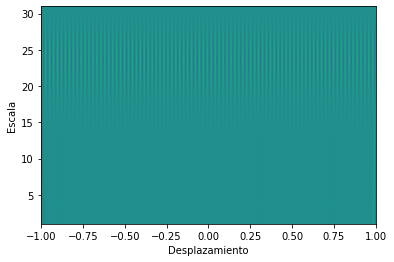

In [58]:
widths = np.arange(1, 32)
cwtmatr = signal.cwt(y, wavelet=signal.ricker, widths=widths) # Continuous wavelet transform, Ricker=mexican hat

print(cwtmatr.shape)
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], aspect='auto' # cmap='PRGn',
           ,vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.xlabel('Desplazamiento')
plt.ylabel('Escala')
plt.show()

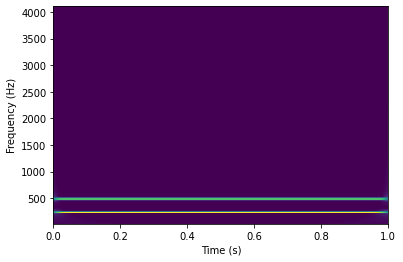

In [125]:
import numpy as np
import matplotlib.pyplot as plt

import obspy # pip3 install obspy
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt

scalogram = cwt(st=y, dt=1.0/Fs, w0=32, fmin=F0[0], fmax=F0[-1]) # morlet

ax = plt.figure().add_subplot(111)
x_axis, y_axis = np.meshgrid(t,np.logspace(np.log10(F0[0]), np.log10(F0[-1]), scalogram.shape[0]))
ax.pcolormesh(x_axis, y_axis, np.abs(scalogram), cmap=obspy_sequential, shading='auto')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (Hz)')
plt.show()

# Conclusiones
En construcción...

# Referencias

1. Wikipedia contributors. (2021, February 17). Mexican hat wavelet. In Wikipedia, The Free Encyclopedia. Retrieved 00:05, March 7, 2021, from https://en.wikipedia.org/w/index.php?title=Mexican_hat_wavelet&oldid=1007284050

2. M. Vetterli, J. Kovacevic. Wavelets and Subband Coding. Orignally published in 1995 by Prentice Hall PTR, Englewood Cliffs, New Jersey. Reissued by authors in 2007.

3. Wikipedia contributors. (2021, March 3). Correlation and dependence. In Wikipedia, The Free Encyclopedia. Retrieved 00:47, March 7, 2021, from https://en.wikipedia.org/w/index.php?title=Correlation_and_dependence&oldid=1010073167

---
<a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/"><img alt="Licencia de Creative Commons" style="border-width:0" src="https://i.creativecommons.org/l/by-nc-nd/4.0/88x31.png" /></a><br/>Este obra está bajo una <a rel="license" href="http://creativecommons.org/licenses/by-nc-nd/4.0/">licencia de Creative Commons Reconocimiento-NoComercial-SinObraDerivada 4.0 Internacional</a>. El sitio [juanfonsecasolis.github.io](https://juanfonsecasolis.github.io) es un blog dedicado a la investigación independiente en temas relacionados al procesamiento digital de señales. Para reutilizar este artículo y citar las fuente por favor utilice el siguiente Bibtex:

```
@online{Fonseca2021,
  author = {Juan M. Fonseca-Solís},
  title = {Desmistificando la transformada de ondeletas},
  year = 2021,
  url = {https://juanfonsecasolis.github.io/blog/JFonseca.wavelets.html},
  urldate = {}
}
```